Notes:

WHY IS W LAM SO LOW IN COMPARISON TO CARCASS?  T IS LOW TOO (THOUGH DONE AT LITTLE DIFFERENTLY BECAUSE 238 REMOVED, BUT NOT AS LOW)


From prelim analysis, we know that there are regions that are differentially bound. What do they look like? They can be big regions, or small regions, or can be clustered or dispersed, or they the same across tissues. 

Do correlation between different datasets of BaseMean and Log2Change value, to answer the question: are areas of high binding the same across protein-line combos?
Line effect hypotheses: 1) If you imagine a simple binary model where the protein either binds or doesn't. The base mean if the protein doesn't bind is low. The peaks of the non-NA regions generally speaking are non-overlapping.
2) Alternatively, some degree of binding. Regions of binding relatively fixed. (Most likely a mix of these two things.) (Depending on this, we might want to reduce our binding data 1's and 0's when comparing to gene expression. This might also impact whether we ultimately try to build an HMM, if on/off an HMM is easy)

Simplify data to just non-NA rows and plot log2 fold change across genome. When you look at the difference between lines if you wnat to plot log2fold change across genome. Send to png.
We tested whether an interaction was significant by doing a NBLRT test. Pull the regions that are significant from the created dataframes. Write a function that take a row number as input, makes a plot. 1) I write to file significant Line by Protein regions (only keep pvalue, padj)

2) select regions with significant line by protein interaction, and draw a plot of the log2change from individual line by protein by tissue analysis (across the dfiferent lines)

Make a Manhattan plot of p-values across genomes (on raw pvalues). color those with padj<.05 in diff color. Do these significant interactions tend to be clustered or dispersed?

Do ACF for these log2fold change for one line by protein tissue combination, or for the main effect of protein across pooled data.

DO a PCA

In [413]:
%matplotlib inline

import glob
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import signal

Read locations dataframe -- this gives you actual location info for a given index

In [216]:
locations_df=pd.read_csv("Locations")
locations_df.head()

,Unnamed: 0,0,1,2
0,0,211000022278049,390,394
1,1,211000022278049,537,541
2,2,211000022278049,573,577
3,3,211000022278049,837,841
4,4,211000022278049,1613,1617


We look at the specific tissue by line by protein datasets (which had information about when there was significant different binding of the protein relative to Dam).  Here we load info for log2FoldChange and baseMean.


In [2]:
lFC=[]
lBM=[]
for f1 in glob.glob("res*"):
    df_FC = pd.read_csv(f1).log2FoldChange
    df_BM = pd.read_csv(f1).baseMean
    lFC.append(df_FC)
    lBM.append(df_BM)
log2FC = pd.concat(lFC, axis = 1)
baseM = pd.concat(lBM, axis = 1)

log2FC.columns= map(lambda x: x[8:], glob.glob("res*"))
log2FC.head()

baseM.columns= map(lambda x: x[8:], glob.glob("res*"))
baseM.head()


,C_D1_188,C_D1_238,C_D1_257,C_D1_89,C_Lam_188,C_Lam_238,C_Lam_257,C_Lam_89,T_D1_188,T_D1_238,...,T_Lam_257,T_Lam_89,W_D1_188,W_D1_238,W_D1_257,W_D1_89,W_Lam_188,W_Lam_238,W_Lam_257,W_Lam_89
0,0.632360,0.219583,0.617413,0.353553,1.423632,0.721288,1.313440,0.166012,1.382349,1.526687,...,0.942010,0.137624,0.667969,0.143726,0.611825,0.949658,0.649690,0.112728,0.568352,0.918350
1,0.444129,0.219583,0.502155,0.163913,1.013380,0.721288,1.087081,0.412760,1.208380,0.138335,...,0.646270,0.137624,0.825459,0.143726,0.310907,1.008575,0.829502,0.094104,0.521248,0.892944
2,0.444129,0.354546,0.502155,0.163913,1.013380,0.889381,0.923345,0.412760,1.323238,0.138335,...,0.646270,0.137624,0.825459,0.143726,0.310907,1.008575,0.829502,0.221549,0.521248,0.892944
3,0.514814,0.716185,0.797342,0.163913,0.410957,1.076175,0.829917,0.246748,0.711324,0.000000,...,0.080143,0.137624,0.785790,0.449538,0.681006,0.460453,0.431993,0.430985,0.323789,0.836915
4,1.048009,0.134962,0.598488,0.516430,1.459705,0.168094,0.788619,1.235139,0.363386,0.293382,...,0.761525,0.137624,0.327046,0.000000,0.462001,0.274345,0.379232,0.127445,0.667081,0.773114


## Looking at correlations

We plot the correlation of the log2FoldChange and the baseMean across these datasets, to see if the degree of binding was roughly the same across datasets, or if it was different.

In [3]:
log2FC.corr()

,C_D1_188,C_D1_238,C_D1_257,C_D1_89,C_Lam_188,C_Lam_238,C_Lam_257,C_Lam_89,T_D1_188,T_D1_238,...,T_Lam_257,T_Lam_89,W_D1_188,W_D1_238,W_D1_257,W_D1_89,W_Lam_188,W_Lam_238,W_Lam_257,W_Lam_89
C_D1_188,1.000000,0.084448,0.185538,0.048137,-0.236155,0.147122,0.126471,0.100072,0.032885,0.049706,...,0.079340,0.065715,0.141441,0.013264,0.145848,0.137106,-0.065214,-0.010504,-0.075181,-0.066353
C_D1_238,0.084448,1.000000,0.054228,0.178134,0.096437,-0.271294,0.027396,0.030398,-0.011205,0.077221,...,0.066633,0.081086,0.021483,-0.058588,0.024476,0.008022,0.036317,0.055740,0.026648,0.053927
C_D1_257,0.185538,0.054228,1.000000,-0.029868,-0.030861,0.033059,-0.262717,0.078458,0.052346,0.073161,...,0.045715,0.126250,0.083694,0.088210,0.077190,0.068603,-0.023298,-0.027299,-0.006077,-0.034937
C_D1_89,0.048137,0.178134,-0.029868,1.000000,0.089943,-0.049428,0.021883,-0.339638,0.058320,0.095046,...,0.047720,0.048361,-0.044062,-0.089370,-0.041100,-0.041480,0.047073,0.054313,0.025007,0.052549
C_Lam_188,-0.236155,0.096437,-0.030861,0.089943,1.000000,0.038597,0.143786,0.263221,-0.095147,-0.072434,...,0.366718,0.290739,-0.208459,-0.211461,-0.117651,-0.174313,0.587279,0.538894,0.557407,0.599971
C_Lam_238,0.147122,-0.271294,0.033059,-0.049428,0.038597,1.000000,0.587456,0.490667,-0.074636,-0.045656,...,0.341898,0.114237,0.215834,-0.065040,0.319535,0.245201,0.147050,0.283936,0.120696,0.134042
C_Lam_257,0.126471,0.027396,-0.262717,0.021883,0.143786,0.587456,1.000000,0.447122,-0.134005,-0.059359,...,0.369278,0.140999,0.193976,-0.070884,0.303794,0.229505,0.247107,0.375128,0.227882,0.243468
C_Lam_89,0.100072,0.030398,0.078458,-0.339638,0.263221,0.490667,0.447122,1.000000,-0.096992,-0.040236,...,0.381550,0.246954,0.118756,-0.081556,0.211372,0.135516,0.294164,0.373508,0.280298,0.301677
T_D1_188,0.032885,-0.011205,0.052346,0.058320,-0.095147,-0.074636,-0.134005,-0.096992,1.000000,0.062777,...,-0.050076,-0.011687,0.008955,0.059679,-0.049022,-0.024542,-0.081879,-0.106526,-0.059483,-0.076827
T_D1_238,0.049706,0.077221,0.073161,0.095046,-0.072434,-0.045656,-0.059359,-0.040236,0.062777,1.000000,...,-0.071289,0.082057,0.009627,-0.054659,-0.012420,-0.030668,-0.136431,-0.089706,-0.127408,-0.130686


In [4]:
baseM.corr()

,C_D1_188,C_D1_238,C_D1_257,C_D1_89,C_Lam_188,C_Lam_238,C_Lam_257,C_Lam_89,T_D1_188,T_D1_238,...,T_Lam_257,T_Lam_89,W_D1_188,W_D1_238,W_D1_257,W_D1_89,W_Lam_188,W_Lam_238,W_Lam_257,W_Lam_89
C_D1_188,1.000000,0.859699,0.903500,0.577807,0.852653,0.772056,0.774150,0.660527,0.528178,0.323899,...,0.823847,0.662813,0.669003,0.659415,0.668474,0.685167,0.530939,0.588978,0.528623,0.553801
C_D1_238,0.859699,1.000000,0.901065,0.676946,0.716033,0.821480,0.642490,0.745046,0.486028,0.290582,...,0.754179,0.715831,0.626257,0.615334,0.636833,0.647831,0.484984,0.552071,0.465054,0.505133
C_D1_257,0.903500,0.901065,1.000000,0.582605,0.779976,0.739546,0.743071,0.627464,0.505470,0.318214,...,0.759417,0.606799,0.713839,0.702525,0.719247,0.729906,0.552480,0.619852,0.535842,0.571464
C_D1_89,0.577807,0.676946,0.582605,1.000000,0.467507,0.572935,0.420523,0.707966,0.359975,0.213704,...,0.537993,0.524421,0.379670,0.377214,0.384651,0.392144,0.304663,0.345675,0.293306,0.315931
C_Lam_188,0.852653,0.716033,0.779976,0.467507,1.000000,0.730718,0.814699,0.626053,0.431985,0.268317,...,0.746451,0.654316,0.627810,0.628546,0.627767,0.627590,0.608568,0.624379,0.617704,0.628959
C_Lam_238,0.772056,0.821480,0.739546,0.572935,0.730718,1.000000,0.782970,0.777930,0.431575,0.234671,...,0.712090,0.718558,0.515164,0.515989,0.519875,0.522511,0.462207,0.493282,0.470289,0.478090
C_Lam_257,0.774150,0.642490,0.743071,0.420523,0.814699,0.782970,1.000000,0.555391,0.419657,0.277471,...,0.723670,0.568403,0.599821,0.597927,0.590711,0.601307,0.565062,0.592005,0.587124,0.586305
C_Lam_89,0.660527,0.745046,0.627464,0.707966,0.626053,0.777930,0.555391,1.000000,0.373564,0.172891,...,0.645149,0.702593,0.399463,0.400888,0.405663,0.403442,0.374020,0.389142,0.372713,0.384320
T_D1_188,0.528178,0.486028,0.505470,0.359975,0.431985,0.431575,0.419657,0.373564,1.000000,0.274286,...,0.514618,0.403302,0.411945,0.401735,0.407227,0.425194,0.330294,0.363460,0.327453,0.348137
T_D1_238,0.323899,0.290582,0.318214,0.213704,0.268317,0.234671,0.277471,0.172891,0.274286,1.000000,...,0.363059,0.221894,0.302990,0.292537,0.290654,0.317452,0.231508,0.267992,0.229819,0.251445


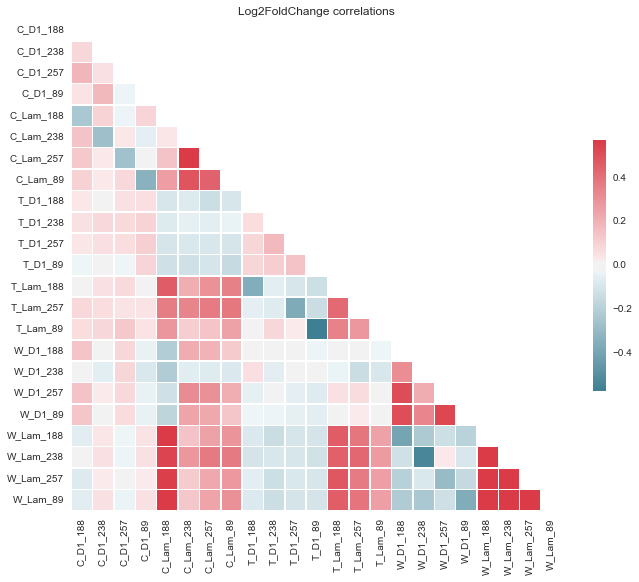

In [5]:
#https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html

sns.set(style="white")

corr=log2FC.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title("Log2FoldChange correlations")

Lam binding in general positively correlated across tissue types.

Places were Lam binds negatively correlated to places where D1 binds.  This is particularly obvious when comparing C_Lam_188 to C_D1_188, C_Lam_238 to C_D1_238, T_Lam_89 to T_D1_89.  ie, the blue diagonal lines, where tissue and line kept the same, just protein different.  

In 20160519_DESeq_DamID-Copy1, we showed that W-Lam does not show much differential binding, although C-Lam did.  This was puzzling. We thought that W-Lam should be an average of carcass and testes, more weighted toward carcass.  We thought that maybe C-Lam and T-Lam were negatively correlated with each other, but they are slightly positively correlated.


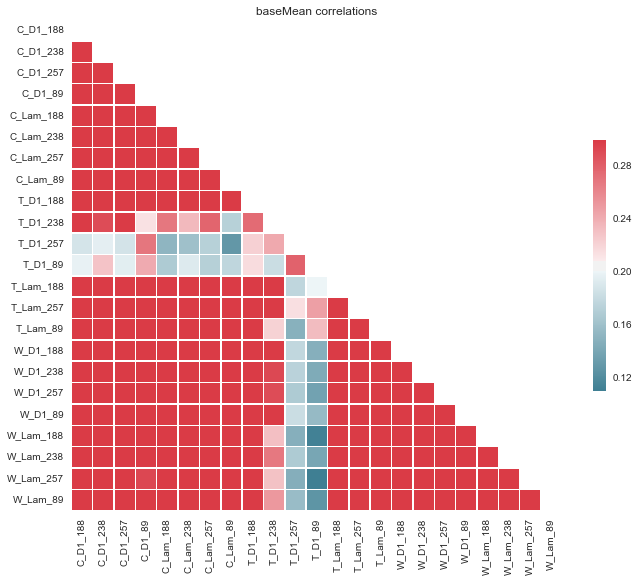

In [157]:
sns.set(style="white")

corr=baseM.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title("baseMean correlations")

not a lot to see in the above graph, except T_D1 negatively correlated with everything else.  In general, T-D1 didn't show much significant binding (see histogram of p-values).

## Plotting PCA

In [277]:
print log2FC.shape
log2FC.dropna().shape

(388464, 23)


(203990, 23)

In [291]:
print [str(ele) for ele in log2FC.columns]

['C_D1_188', 'C_D1_238', 'C_D1_257', 'C_D1_89', 'C_Lam_188', 'C_Lam_238', 'C_Lam_257', 'C_Lam_89', 'T_D1_188', 'T_D1_238', 'T_D1_257', 'T_D1_89', 'T_Lam_188', 'T_Lam_257', 'T_Lam_89', 'W_D1_188', 'W_D1_238', 'W_D1_257', 'W_D1_89', 'W_Lam_188', 'W_Lam_238', 'W_Lam_257', 'W_Lam_89']


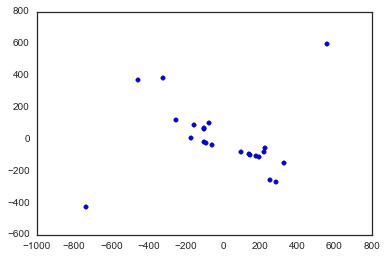

In [297]:
for i, lab in zip(range(23),['C_D1_188', 'C_D1_238', 'C_D1_257', 'C_D1_89', 'C_Lam_188', 'C_Lam_238', 'C_Lam_257', 'C_Lam_89', 'T_D1_188', 'T_D1_238', 'T_D1_257', 'T_D1_89', 'T_Lam_188', 'T_Lam_257', 'T_Lam_89', 'W_D1_188', 'W_D1_238', 'W_D1_257', 'W_D1_89', 'W_Lam_188', 'W_Lam_238', 'W_Lam_257', 'W_Lam_89']):
    plt.scatter(X[i, 0], X[i, 1],label=lab)

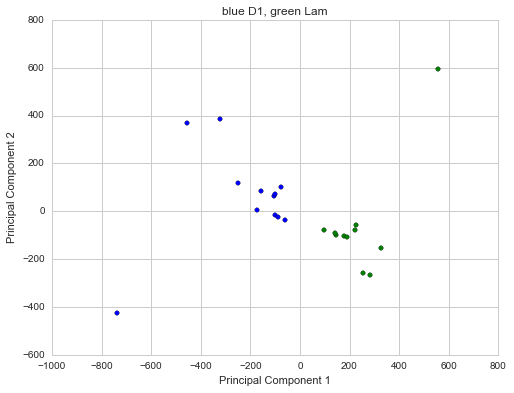

In [311]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    d={"blue":"D1", "green":"Lam"}
    for i, lab in enumerate(['C_D1_188', 'C_D1_238', 'C_D1_257', 'C_D1_89', 'C_Lam_188', 'C_Lam_238', 'C_Lam_257', 'C_Lam_89', 'T_D1_188', 'T_D1_238', 'T_D1_257', 'T_D1_89', 'T_Lam_188', 'T_Lam_257', 'T_Lam_89', 'W_D1_188', 'W_D1_238', 'W_D1_257', 'W_D1_89', 'W_Lam_188', 'W_Lam_238', 'W_Lam_257', 'W_Lam_89']):
        if 'D1' in lab:
            col="blue"
        else:
            col="green"
        plt.scatter(X[i, 0],
                    X[i, 1],
                    label=d[col],
                    c=col)
        #plt.annotate(lab,X[i, 0],X[i, 1])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title("blue D1, green Lam")
    
    #plt.legend(loc='lower left')
    plt.show()

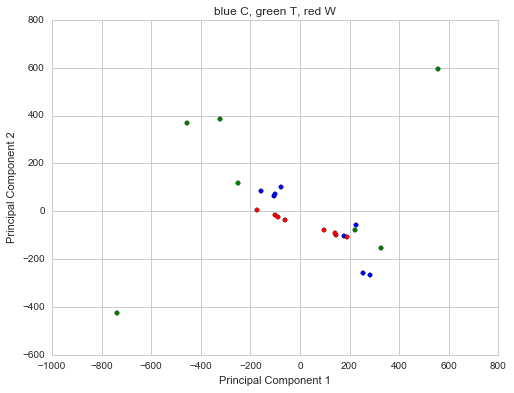

In [316]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    for i, lab in enumerate(['C_D1_188', 'C_D1_238', 'C_D1_257', 'C_D1_89', 'C_Lam_188', 'C_Lam_238', 'C_Lam_257', 'C_Lam_89', 'T_D1_188', 'T_D1_238', 'T_D1_257', 'T_D1_89', 'T_Lam_188', 'T_Lam_257', 'T_Lam_89', 'W_D1_188', 'W_D1_238', 'W_D1_257', 'W_D1_89', 'W_Lam_188', 'W_Lam_238', 'W_Lam_257', 'W_Lam_89']):
        if 'C' in lab:
            col="blue"
        elif "T" in lab:
            col="green"
        else:
            col="red"
        plt.scatter(X[i, 0],
                    X[i, 1],
                    c=col)
        #plt.annotate(lab,X[i, 0],X[i, 1])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title("blue C, green T, red W")
    
    #plt.legend(loc='lower left')
    plt.show()

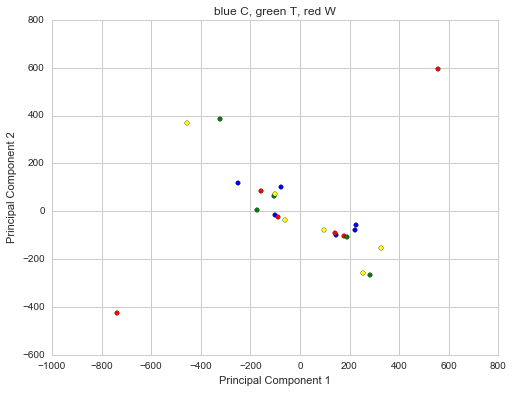

In [321]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    for i, lab in enumerate(['C_D1_188', 'C_D1_238', 'C_D1_257', 'C_D1_89', 'C_Lam_188', 'C_Lam_238', 'C_Lam_257', 'C_Lam_89', 'T_D1_188', 'T_D1_238', 'T_D1_257', 'T_D1_89', 'T_Lam_188', 'T_Lam_257', 'T_Lam_89', 'W_D1_188', 'W_D1_238', 'W_D1_257', 'W_D1_89', 'W_Lam_188', 'W_Lam_238', 'W_Lam_257', 'W_Lam_89']):
        if '188' in lab:
            col="blue"
        elif "238" in lab:
            col="green"
        elif "257" in lab:
            col="yellow"
        else:
            col="red"
        plt.scatter(X[i, 0],
                    X[i, 1],
                    c=col)
        #plt.annotate(lab,X[i, 0],X[i, 1])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title("blue C, green T, red W")
    
    #plt.legend(loc='lower left')
    plt.show()

## Plot of Log2FoldChange at single locus

pval and padj datasets capture the loci where there is differential expression (ie we did a lrt test between full model: protein + line + line:protein, and reduced model: protein + line

In [9]:
lpadj=[]
lpval=[]
for f1 in glob.glob("nbin*"):
    df_padj = pd.read_csv(f1).padj
    df_pval = pd.read_csv(f1).pvalue
    lpadj.append(df_padj)
    lpval.append(df_pval)
pval = pd.concat(lpval, axis = 1)
padj = pd.concat(lpadj, axis = 1)

pval.columns= map(lambda x: x[25:], glob.glob("nbin*"))
pval.head()

padj.columns= map(lambda x: x[25:], glob.glob("nbin*"))
padj.head()


,C_D1,C_Lam,T_D1,T_Lam,W_D1,W_Lam
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN


Here we simply look at the number or regions with significant binding across various protein line combos

In [11]:
for tissue in ["C", "W", "T"]:
    for protein in ["D1", "Lam"]:
        print tissue, protein
        print sum(padj[tissue+'_'+protein] <.1)

C D1
4113
C Lam
52874
W D1
45
W Lam
268
T D1
4351
T Lam
2974


In [198]:
tissue="C"
protein = "Lam"
places_where_sig_interaction=padj[tissue+'_'+ protein][padj[tissue+'_'+ protein]<.05].index.values

places_where_sig_interaction[:10]

array([791, 792, 793, 799, 800, 801, 802, 805, 806, 807])

Here we plot log2FC at differentially expressed loci.

For this, first we need the standard error of the log2FC.

In [226]:
lSE=[]
for f1 in glob.glob("res*"):
    df_SE = pd.read_csv(f1).lfcSE
    lSE.append(df_SE)
log2FC_SE = pd.concat(lSE, axis = 1)

log2FC_SE.columns= map(lambda x: x[8:], glob.glob("res*"))
log2FC_SE.head()



,C_D1_188,C_D1_238,C_D1_257,C_D1_89,C_Lam_188,C_Lam_238,C_Lam_257,C_Lam_89,T_D1_188,T_D1_238,...,T_Lam_257,T_Lam_89,W_D1_188,W_D1_238,W_D1_257,W_D1_89,W_Lam_188,W_Lam_238,W_Lam_257,W_Lam_89
0,2.261231,1.011361,0.853395,1.831381,1.031711,1.745913,1.263923,1.256683,1.702696,2.222696,...,1.507113,2.604603,0.564407,0.487509,0.679231,0.588196,0.874599,0.732187,0.722515,0.871087
1,2.196334,1.011361,0.825891,1.782538,1.107553,1.745913,1.311158,1.352729,1.710971,2.417533,...,1.597168,2.604603,0.587467,0.487509,0.535668,0.591310,0.890444,0.728667,0.712127,0.866845
2,2.196334,1.116278,0.825891,1.782538,1.107553,1.623521,1.364217,1.352729,1.703465,2.417533,...,1.597168,2.604603,0.587467,0.487509,0.535668,0.591310,0.890444,0.848518,0.712127,0.866845
3,2.272568,1.243133,0.885932,1.782538,1.191664,1.571576,1.424385,1.289411,1.724946,NaN,...,1.462197,2.604603,0.589069,0.722400,0.689573,0.481995,0.794488,0.990526,0.638861,0.868326
4,2.268865,0.989674,0.850234,1.890612,1.007908,1.839987,1.393682,1.530416,1.670485,2.425427,...,1.535477,2.604603,0.451394,NaN,0.611789,0.411629,0.777137,0.734450,0.758188,0.873044


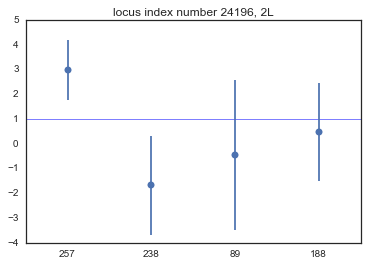

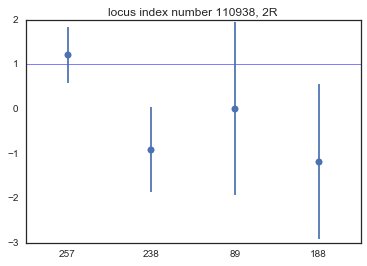

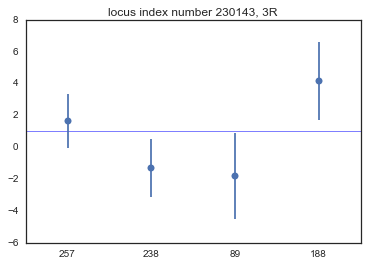

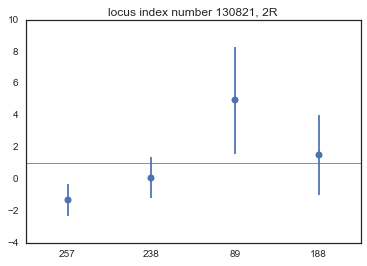

In [273]:
#We plot the mean +- 1.96SE

def plot_graph_at_diff_expressed_locus(tissue, protein, padj, locations_df, log2FC_SE, sample_size=4):
    #Gather a list of random places in the genome of size sample_size
    places_where_sig_interaction=padj[tissue+'_'+ protein][padj[tissue+'_'+ protein]<.05].index.values
    
    #Plot some of these differentially expressed graphs
    for loc in np.random.choice(places_where_sig_interaction, size=sample_size, replace=False):
        val=[log2FC[tissue + '_'+ protein + '_' + line][loc] for line in ["257","238","89","188"]]
        SE=[1.96* log2FC_SE[tissue + '_'+ protein + '_' + line][loc] for line in ["257","238","89","188"]]

        plt.figure()
        ax = plt.subplot(111)
        ax.errorbar(range(4),val, yerr=SE, linestyle='None', fmt='o')
        ax.set_title("locus index number " + str(loc) + ', ' +str(locations_df.loc[loc]["0"]))
        ax.set_xticks(np.arange(4))
        ax.set_xticklabels(["257","238","89","188"])
        ax.set_xlim(left=-.5, right=3.5)
        ax.axhline(y=1,xmin=0,xmax=3.5,linewidth=0.5,zorder=0)
        plt.show()

plot_graph_at_diff_expressed_locus("C","D1",padj, locations_df, log2FC_SE)

## Plot log2FC across genome

This is the wrong p-value. it is the p-value for there having been a significant interaction.  We plot every 100'th element so things are thinned out a bit.  Maybe we should just plot an element if it is similar to the previous locus?

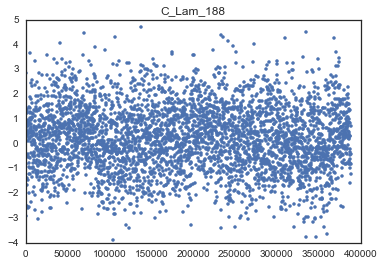

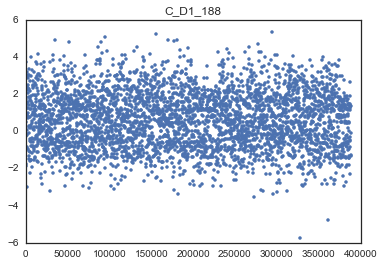

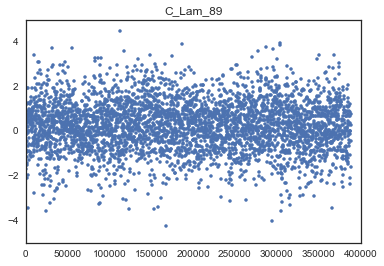

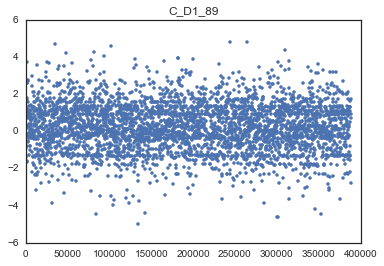

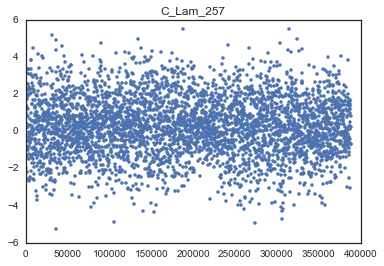

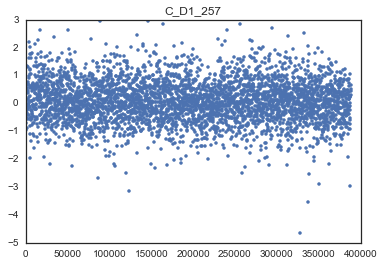

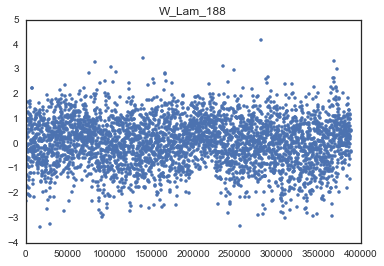

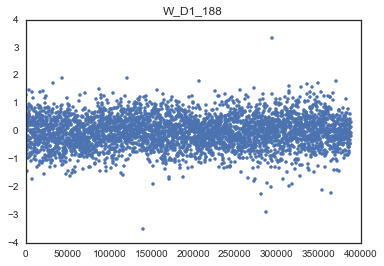

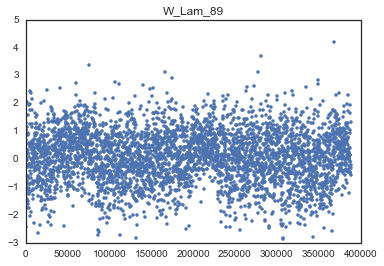

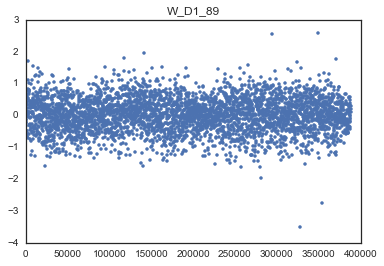

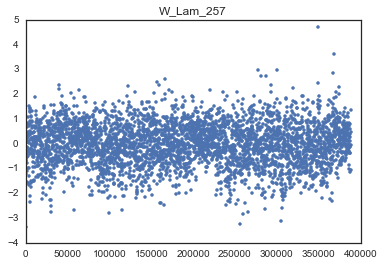

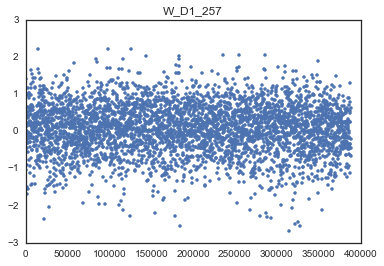

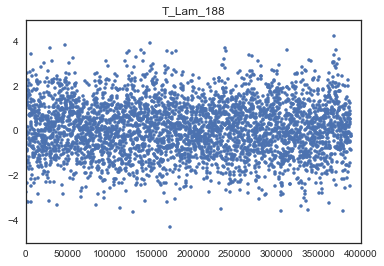

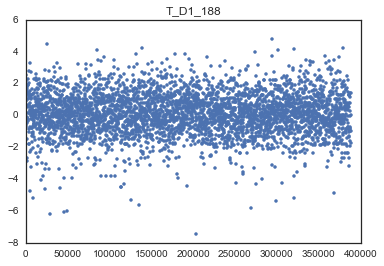

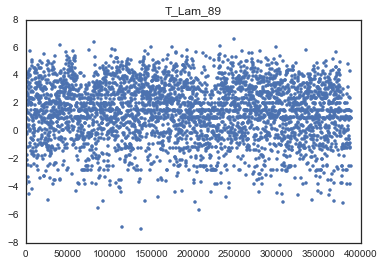

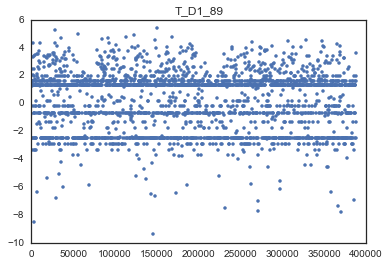

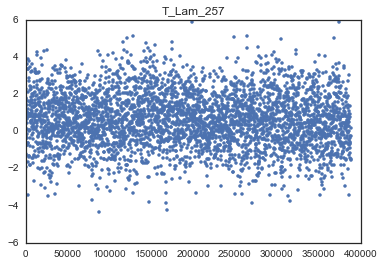

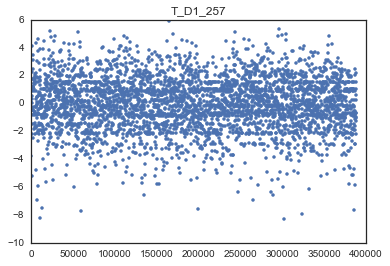

In [323]:
def plot_log2FC(tissue, protein, line):
    f, ax = plt.subplots()
    #plt.plot(log2FC[tissue + '_'+ protein + '_' + line][padj[tissue+'_'+protein] <.05], '.')
    plt.plot(log2FC[tissue + '_'+ protein + '_' + line][::100], '.')
    plt.title(tissue + '_'+ protein + '_' + line)

for tissue in ["C","W", "T"]:
    for line in ["188","89","257"]:
        for protein in ["Lam", "D1"]:
            plot_log2FC(tissue, protein, line)
    

overall, it's very difficult to see anything.  We do see a consistent blank between 60000 and 80000 (across Lam and D1)

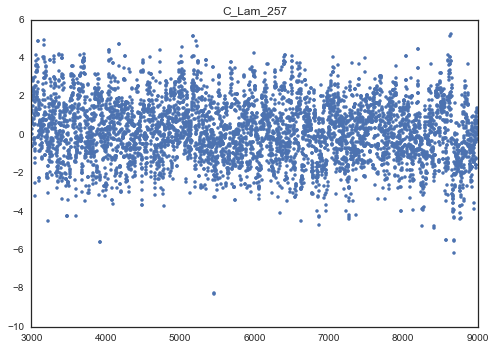

In [178]:
protein="Lam"
line="257"
tissue="C"

f, ax = plt.subplots()
#plt.plot(log2FC[tissue + '_'+ protein + '_' + line][padj[tissue+'_'+protein] <.05][3000:9000], '.')
plt.plot(log2FC[tissue + '_'+ protein + '_' + line][3000:9000], '.')
plt.title(tissue + '_'+ protein + '_' + line)

Here we try to see that it corresponds to location 2R.

In [50]:
locations_df.loc[64000:78000,].groupby("0").count()

,Unnamed: 0,1,2
0,,,
2R,14001,14001,14001


There is a second consistent blank band around 200000-230000.  This corresponds to 3L and 3R.

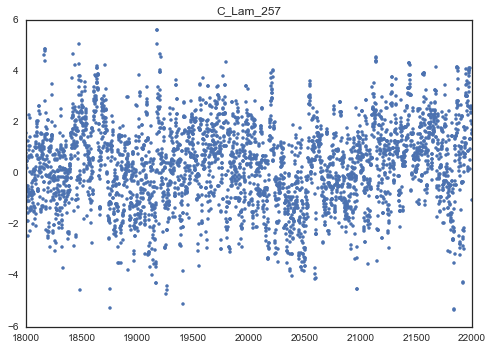

In [179]:
protein="Lam"
line="257"
tissue="C"

f, ax = plt.subplots()
#plt.plot(log2FC[tissue + '_'+ protein + '_' + line][padj[tissue+'_'+protein] <.05][18000:22000], '.')
plt.plot(log2FC[tissue + '_'+ protein + '_' + line][18000:22000], '.')
plt.title(tissue + '_'+ protein + '_' + line)

In [44]:
locations_df.loc[205000:230000,].groupby("0").count()

,Unnamed: 0,1,2
0,,,
3L,11357,11357,11357
3R,13644,13644,13644


A third thin white band around 320000.  These correspond to the unmapped scaffolds.

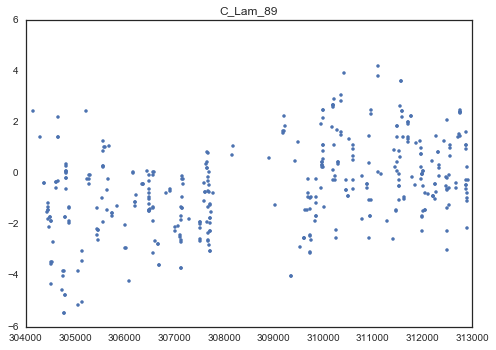

In [64]:
protein="Lam"
line="89"
tissue="C"

f, ax = plt.subplots()
plt.plot(log2FC[tissue + '_'+ protein + '_' + line][padj[tissue+'_'+protein] <.05][27100:27500], '.')
plt.title(tissue + '_'+ protein + '_' + line)

In [65]:
locations_df.loc[308000:309000,].groupby("0").count()

,Unnamed: 0,1,2
0,,,
Unmapped_Scaffold_22_D1753,119,119,119
Unmapped_Scaffold_24_D1707,25,25,25
Unmapped_Scaffold_28_D1723,87,87,87
Unmapped_Scaffold_29_D1705,96,96,96
Unmapped_Scaffold_32_D1773,19,19,19
Unmapped_Scaffold_35_D1599,160,160,160
Unmapped_Scaffold_37_D1608,50,50,50
Unmapped_Scaffold_38_D1625,70,70,70
Unmapped_Scaffold_44_D1670,69,69,69


## Manhattan plots of p-values across genome for each protein by line by tissue

In [71]:
lpadjManhatt=[]
lpvalManhatt=[]
for f1 in glob.glob("res*"):
    df_padjManhatt = pd.read_csv(f1).padj
    df_pvalManhatt = pd.read_csv(f1).pvalue
    lpadjManhatt.append(df_padjManhatt)
    lpvalManhatt.append(df_pvalManhatt)
pvalManhatt = pd.concat(lpvalManhatt, axis = 1)
padjManhatt = pd.concat(lpadjManhatt, axis = 1)

pvalManhatt.columns= map(lambda x: x[8:], glob.glob("res*"))
pvalManhatt.head()

padjManhatt.columns= map(lambda x: x[8:], glob.glob("res*"))
padjManhatt.head()

,C_D1_188,C_D1_238,C_D1_257,C_D1_89,C_Lam_188,C_Lam_238,C_Lam_257,C_Lam_89,T_D1_188,T_D1_238,...,T_Lam_257,T_Lam_89,W_D1_188,W_D1_238,W_D1_257,W_D1_89,W_Lam_188,W_Lam_238,W_Lam_257,W_Lam_89
0,NaN,0.995655,0.998638,NaN,NaN,NaN,NaN,NaN,0.999352,NaN,...,NaN,0.856952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.995655,0.998638,NaN,NaN,NaN,NaN,NaN,0.999352,NaN,...,NaN,0.856952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0.995655,0.998638,NaN,NaN,NaN,NaN,NaN,0.999352,NaN,...,NaN,0.856952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.995655,0.998638,NaN,NaN,NaN,NaN,NaN,0.999352,NaN,...,NaN,0.856952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,0.995655,0.998638,NaN,NaN,NaN,NaN,NaN,0.999352,NaN,...,NaN,0.856952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


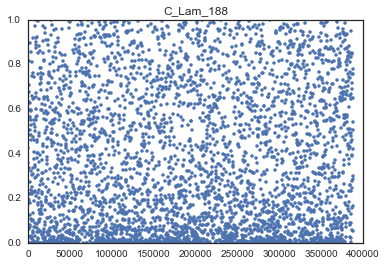

In [324]:
protein="Lam"
line="188"
tissue="C"

f, ax = plt.subplots()
plt.plot(pvalManhatt[tissue + '_'+ protein + '_' + line][::100], '.')
plt.title(tissue + '_'+ protein + '_' + line)

ha.  We plot in a restricted range.

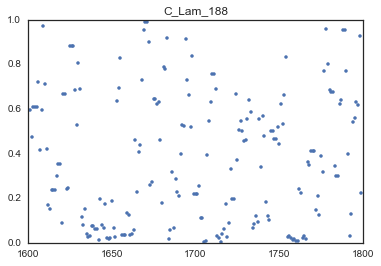

In [412]:
protein="Lam"
line="188"
tissue="C"

f, ax = plt.subplots()
plt.plot(pvalManhatt[tissue + '_'+ protein + '_' + line][1600:1800], '.')
plt.title(tissue + '_'+ protein + '_' + line)
plt.show()


#window=gaussian(20, 10)
#ga = filters.convolve1d(pvalManhatt[tissue + '_'+ protein + '_' + line][1600:1800], window/window.sum())
#plt.plot(range(1600,1800), ga)



# convolve the arrays
#smoothed = scipy.signal.convolve(yy, window/window.sum(), mode='same')

It's difficult to read anything from this plot, so we creat a binary: either p-value is significant or not.  We plot in a restricted range.  There are definitely areas where you have significant binding.

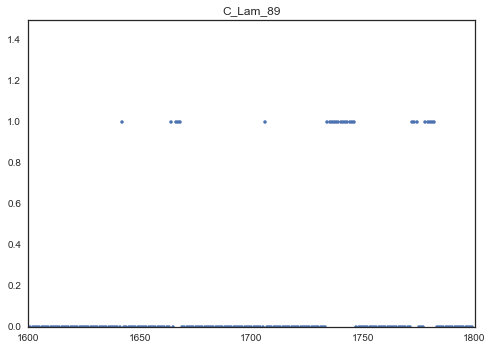

In [153]:
protein="Lam"
line="89"
tissue="C"

f, ax = plt.subplots()
plt.plot((pvalManhatt[tissue + '_'+ protein + '_' + line] <.1)[1600:1800], '.')
plt.ylim([0,1.5])
plt.title(tissue + '_'+ protein + '_' + line)

Let's now plot a histogram of the length of these significant region for any region greater than 1.  We see for this that the length of the significant tracts much longer for Lam than D1.  We are counting NAs as non-significant.

15
130


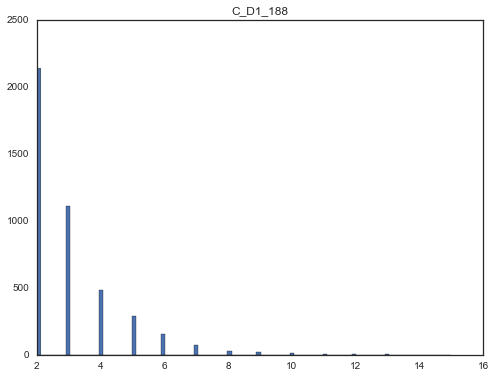

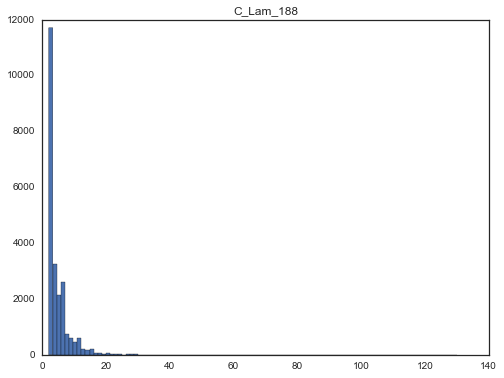

In [352]:
def plot_histogram_length_significant_spots(protein, tissue, line):
    sig_length=[]
    indices_of_sig_length=[]
    counter = 0
    for i,ele in enumerate(pvalManhatt[tissue + '_'+ protein + '_' + line] <.1):
        if ele:
            counter+=1
        else:
            if counter>1:
                sig_length.append(counter)
                indices_of_sig_length.append(i)
            counter=0

    plt.figure(figsize=[8,6])
    _=plt.hist(sig_length, bins=100)
    plt.title(tissue + '_'+ protein + '_' + line)

    print max(sig_length)
    
plot_histogram_length_significant_spots("D1", "C", "188")
plot_histogram_length_significant_spots("Lam", "C", "188")

Here I allow there to be some flexibility by allowing maximum 4 non-significant p-vals to get a pass.

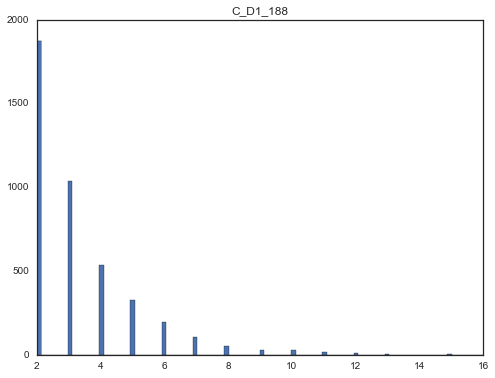

16


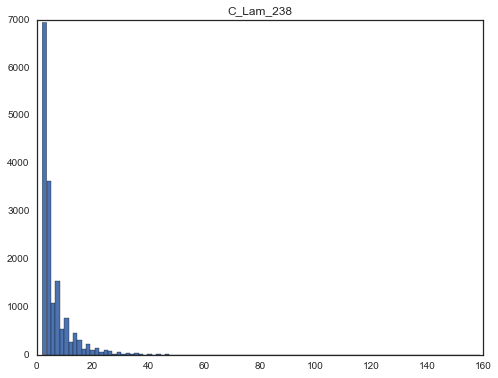

159


In [378]:
def plot_histogram_length_significant_spots_flexible(protein, tissue, line):
    sig_length=[]
    indices_of_sig_length=[]
    blank_spaces=0
    counter = 0
    for i,ele in enumerate(pvalManhatt[tissue + '_'+ protein + '_' + line] <.1):
        if ele:
            counter+=1
        else:
            blank_spaces+=1
            if blank_spaces > 4:
                if counter > 1:
                    sig_length.append(counter)
                    indices_of_sig_length.append(i)
                    #print i
                blank_spaces = 0
                counter=0

    plt.figure(figsize=[8,6])
    _=plt.hist(sig_length, bins=100)
    plt.title(tissue + '_'+ protein + '_' + line)
    plt.show()

    print max(sig_length)
    
plot_histogram_length_significant_spots_flexible("D1", "C", "188")
plot_histogram_length_significant_spots_flexible("Lam", "C", "238")

In C Lam 188, the region with 134 significant p-values in a row is on chromosome 3L.

In [364]:
locations_df.loc[137875-134]

Unnamed: 0    137741
0                 3L
1                620
2                624
Name: 137741, dtype: object

Let's plot the p-values in that region

409


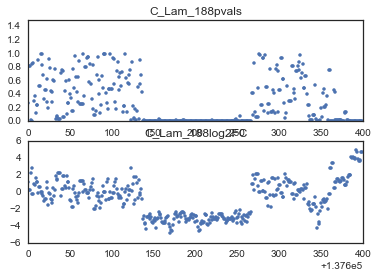

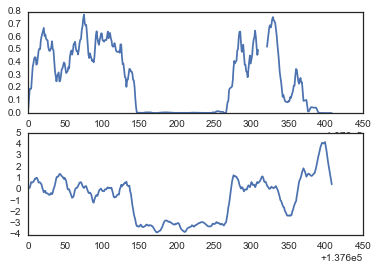

In [423]:
protein="Lam"
line="188"
tissue="C"

f, ax = plt.subplots(2)
ax[0].plot(pvalManhatt[tissue + '_'+ protein + '_' + line] [137600:138000], '.')
ax[0].set_ylim([0,1.5])
ax[0].set_title(tissue + '_'+ protein + '_' + line + "pvals")

ax[1].plot(log2FC[tissue + '_'+ protein + '_' + line] [137600:138000], '.')
#plt.ylim([0,1.5])
plt.title(tissue + '_'+ protein + '_' + line+ "log2FC")


f, ax = plt.subplots(2)
# make a gaussian window
window = signal.gaussian(10, 100)
ga = signal.convolve(pvalManhatt[tissue + '_'+ protein + '_' + line][137600:138000], window/window.sum())
print len(ga)

ax[0].plot(range(137600,137600+len(ga)), ga)
ga = signal.convolve(log2FC[tissue + '_'+ protein + '_' + line][137600:138000], window/window.sum())
ax[1].plot(range(137600,137600+len(ga)), ga)

Let's see what that region looks like over other line protein tissue combos

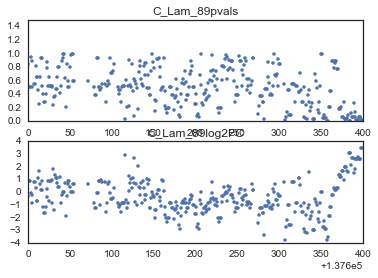

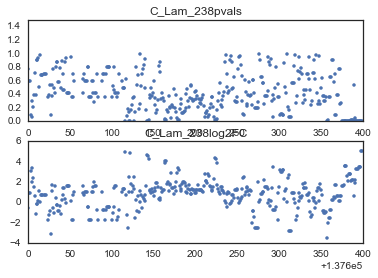

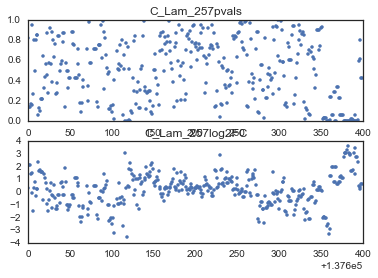

In [394]:
protein="Lam"
line="89"
tissue="C"

f, ax = plt.subplots(2)
ax[0].plot(pvalManhatt[tissue + '_'+ protein + '_' + line] [137600:138000], '.')
ax[0].set_ylim([0,1.5])
ax[0].set_title(tissue + '_'+ protein + '_' + line + "pvals")

ax[1].plot(log2FC[tissue + '_'+ protein + '_' + line] [137600:138000], '.')
#plt.ylim([0,1.5])
plt.title(tissue + '_'+ protein + '_' + line+ "log2FC")

protein="Lam"
line="238"
tissue="C"

f, ax = plt.subplots(2)
ax[0].plot(pvalManhatt[tissue + '_'+ protein + '_' + line] [137600:138000], '.')
ax[0].set_ylim([0,1.5])
ax[0].set_title(tissue + '_'+ protein + '_' + line + "pvals")

ax[1].plot(log2FC[tissue + '_'+ protein + '_' + line] [137600:138000], '.')
#plt.ylim([0,1.5])
plt.title(tissue + '_'+ protein + '_' + line+ "log2FC")

protein="Lam"
line="257"
tissue="C"

f, ax = plt.subplots(2)
ax[0].plot(pvalManhatt[tissue + '_'+ protein + '_' + line] [137600:138000], '.')
ax[0].set_title(tissue + '_'+ protein + '_' + line + "pvals")

ax[1].plot(log2FC[tissue + '_'+ protein + '_' + line] [137600:138000], '.')
#plt.ylim([0,1.5])
plt.title(tissue + '_'+ protein + '_' + line+ "log2FC")

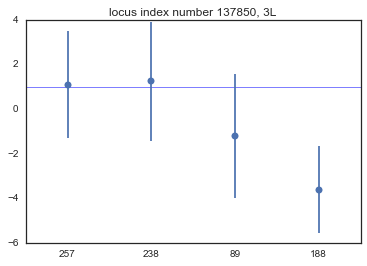

In [393]:
protein="Lam"
tissue="C"
loc=137850

val=[log2FC[tissue + '_'+ protein + '_' + line][loc] for line in ["257","238","89","188"]]
SE=[1.96* log2FC_SE[tissue + '_'+ protein + '_' + line][loc] for line in ["257","238","89","188"]]

plt.figure()
ax = plt.subplot(111)
ax.errorbar(range(4),val, yerr=SE, linestyle='None', fmt='o')
ax.set_title("locus index number " + str(loc) + ', ' +str(locations_df.loc[loc]["0"]))
ax.set_xticks(np.arange(4))
ax.set_xticklabels(["257","238","89","188"])
ax.set_xlim(left=-.5, right=3.5)
ax.axhline(y=1,xmin=0,xmax=3.5,linewidth=0.5,zorder=0)
plt.show()

In C Lam 257, the region with 127 significant p-values in a row is on chromosome 2R (it is a different region!)

In [368]:
locations_df.loc[89115-127]

Unnamed: 0      88981
0                  2R
1             8443994
2             8443998
Name: 88981, dtype: object

In C Lam 238, the region with 159 significant p-values in a row is on chromosome 2L (it is a different region!)

In [372]:
locations_df.loc[15272-159]


Unnamed: 0      15113
0                  2L
1             5123749
2             5123753
Name: 15113, dtype: object

Now let's get an idea of how dispersed regions of significance are (region of significant is 5 or more p-values <.1).  The average distance of D1 C 188 is 131, and for Lam is 17.  We dropped NAs.  So things look very dispersed on average.

The notation is reversed because I took plot_histogram_length_significant_spots_flexible and flipped the sign on pvalManhatt[tissue + '_'+ protein + '_' + line].dropna() <.1 to get the length of the non-significant regions.

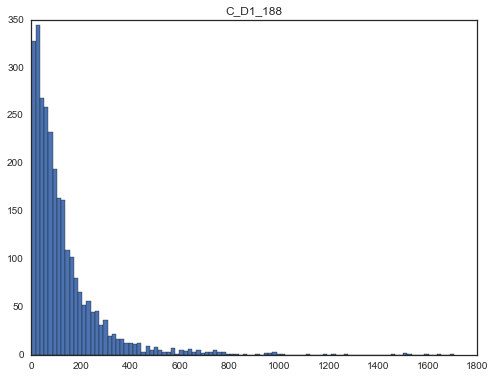

1705 max
131.430604982 mean


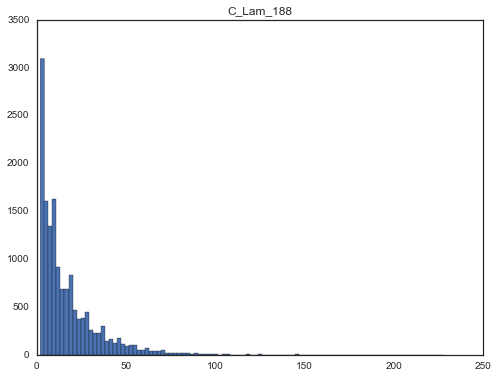

228 max
17.252233768 mean


In [431]:
def plot_histogram_length_NONsignificant_spots_flexible(protein, tissue, line):
    sig_length=[]
    indices_of_sig_length=[]
    blank_spaces=0
    counter = 0
    for i,ele in enumerate(pvalManhatt[tissue + '_'+ protein + '_' + line].dropna() >.1):
        if ele:
            counter+=1
        else:
            blank_spaces+=1
            if blank_spaces > 5:
                if counter > 1:
                    sig_length.append(counter)
                    indices_of_sig_length.append(i)
                    #print i
                blank_spaces = 0
                counter=0

    plt.figure(figsize=[8,6])
    _=plt.hist(sig_length, bins=100)
    plt.title(tissue + '_'+ protein + '_' + line)
    plt.show()

    print max(sig_length), "max"
    print np.mean(sig_length), "mean"
    
plot_histogram_length_NONsignificant_spots_flexible("D1", "C", "188")
plot_histogram_length_NONsignificant_spots_flexible("Lam", "C", "188")

now let's look at the distribution of p-values for these line by protein datasets.  in the aggregate, there is signal of significant binding.

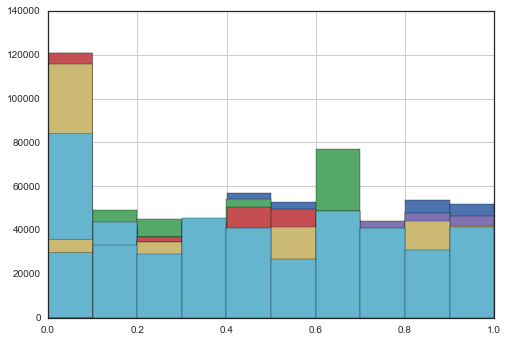

In [99]:
for protein in ["Lam", "D1"]:
    for line in ["89", "188", "257"]:
        for tissue in ["C","T"]:
            pvalManhatt[tissue + '_'+ protein + '_' + line].hist()

let's look at the non-stacked version of the above plot.  we see that all protein by line combos don't show all that significant p-values.

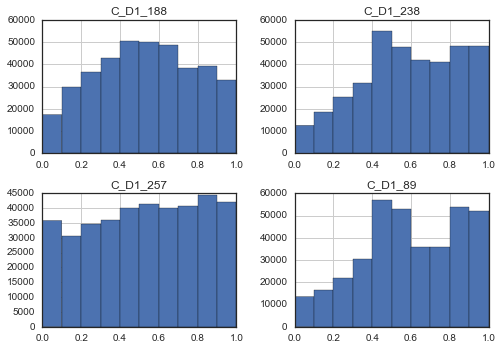

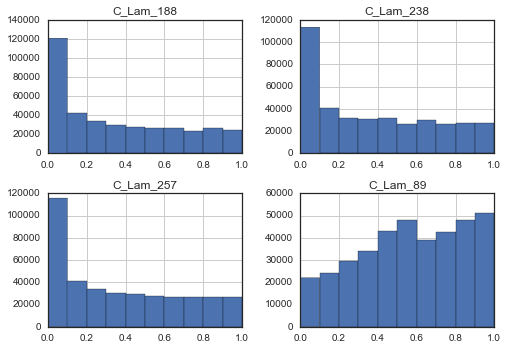

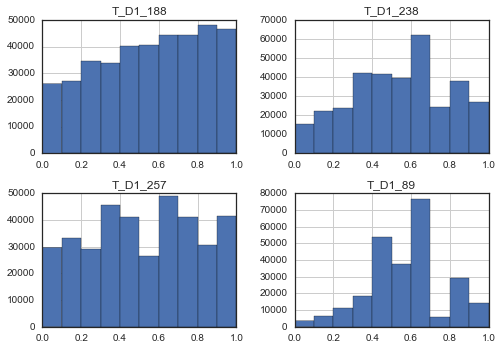

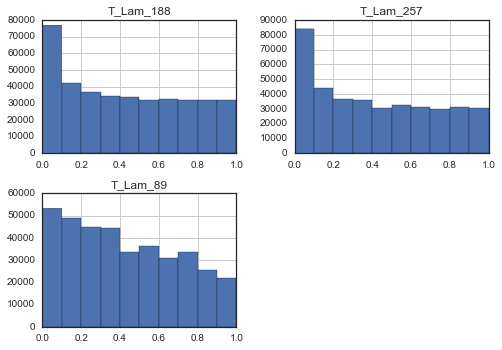

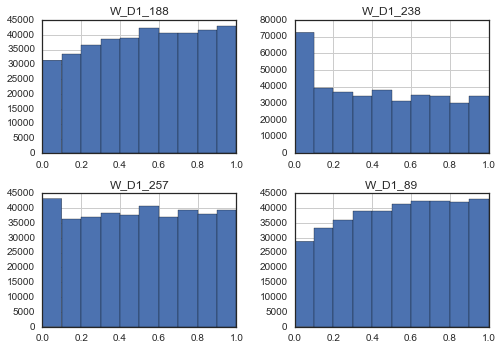

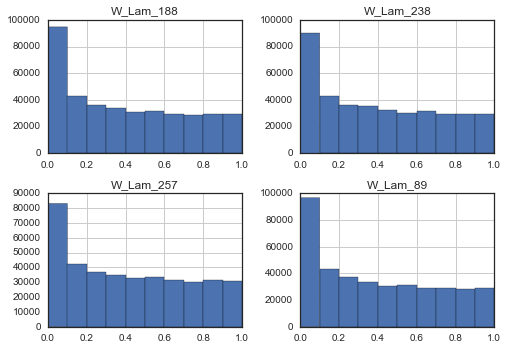

In [120]:
#C D1
_=plt.figure()
pvalManhatt.ix[:,:4].hist()
plt.show()

#C Lam
_=plt.figure()
pvalManhatt.ix[:,4:8].hist()
plt.show()

_=plt.figure()
pvalManhatt.ix[:,8:12].hist()
plt.show()

_=plt.figure()
pvalManhatt.ix[:,12:15].hist()
plt.show()

_=plt.figure()
pvalManhatt.ix[:,15:19].hist()
plt.show()

_=plt.figure()
pvalManhatt.ix[:,19:].hist()
plt.show()

The W-Lam case is interesting, because it did not show a whole lot of differential binding by line, but it clearly is binding.  In our correlation plot, we saw that W-Lams were most correlated to each other.  So not a whole lot of differential binding, but strong binding nonetheless.

W-D1 238 and 257 show some signal of binding.

T-D1 basically shows nothing significant for anything.

C-Lam 89 very different signal from the other C-Lams.  Remember, strongest differential binding was for C-Lams. (I wonder if we would see this pattern if we removed 89, because 89 doesn't seem to differentially bind to anything, but then again there was a high correlation in log2FC across C-Lams).

C-D1 also doesn't show much.

## Calculating ACF

We calculate the ACF of the log2fold change for each line by protein tissue combination.  There is pretty strong autocorrelation, but only for the Lams.

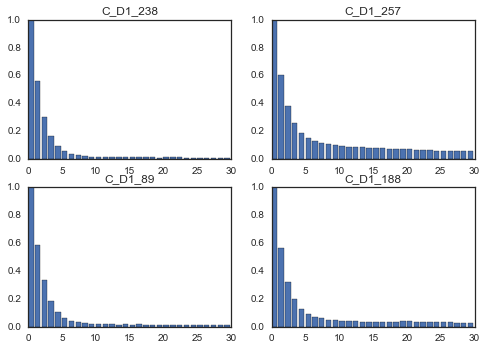

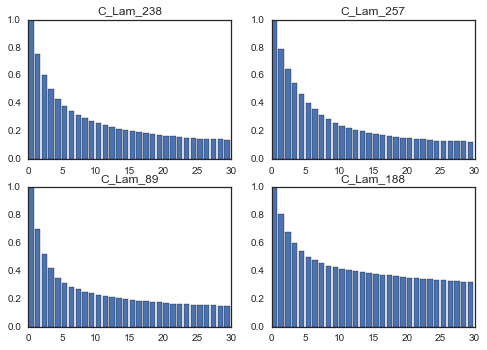

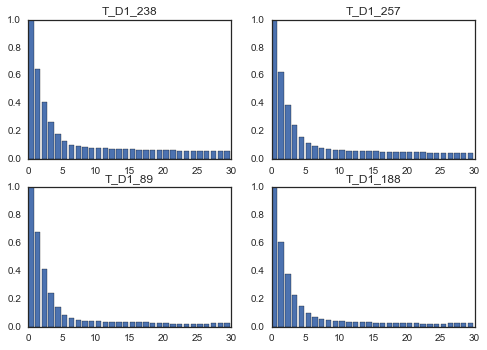

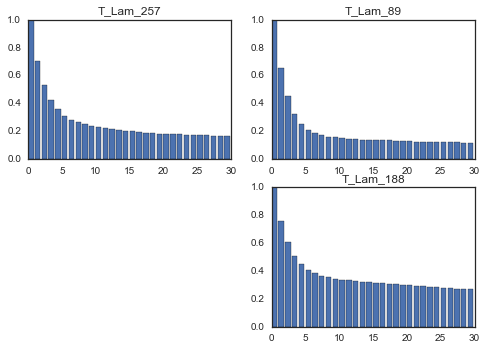

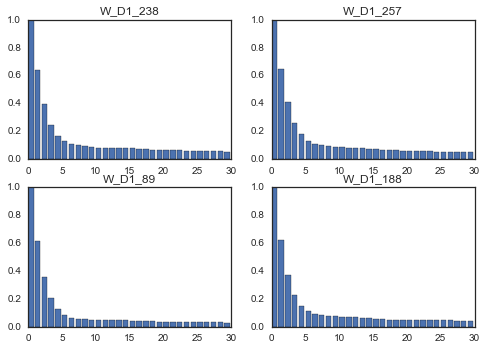

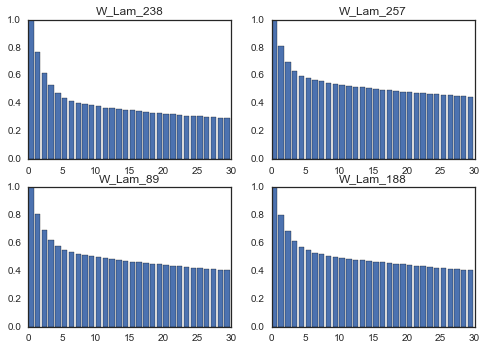

In [173]:
LAGS = 30
fig = plt.figure()
for i,col in enumerate(log2FC.columns[:4]):
    subplot_num='22'+str(i)
    fig.add_subplot(subplot_num)
    _=plt.bar(range(LAGS),[log2FC[col].autocorr(i) for i in range(LAGS)])
    plt.title(col)
    
fig = plt.figure()
for i,col in enumerate(log2FC.columns[4:8]):
    subplot_num='22'+str(i)
    fig.add_subplot(subplot_num)
    _=plt.bar(range(LAGS),[log2FC[col].autocorr(i) for i in range(LAGS)])
    plt.title(col)

    
fig = plt.figure()
for i,col in enumerate(log2FC.columns[8:12]):
    subplot_num='22'+str(i)
    fig.add_subplot(subplot_num)
    _=plt.bar(range(LAGS),[log2FC[col].autocorr(i) for i in range(LAGS)])
    plt.title(col)

    
fig = plt.figure()
for i,col in enumerate(log2FC.columns[12:15]):
    subplot_num='22'+str(i)
    fig.add_subplot(subplot_num)
    _=plt.bar(range(LAGS),[log2FC[col].autocorr(i) for i in range(LAGS)])
    plt.title(col)
    
fig = plt.figure()
for i,col in enumerate(log2FC.columns[15:19]):
    subplot_num='22'+str(i)
    fig.add_subplot(subplot_num)
    _=plt.bar(range(LAGS),[log2FC[col].autocorr(i) for i in range(LAGS)])
    plt.title(col)


fig = plt.figure()
for i,col in enumerate(log2FC.columns[19:]):
    subplot_num='22'+str(i)
    fig.add_subplot(subplot_num)
    _=plt.bar(range(LAGS),[log2FC[col].autocorr(i) for i in range(LAGS)])
    plt.title(col)

